In [1]:
#import packages
from PDE_FIND3 import *
from model_selection_IP3 import *
from collections import Counter
import numpy as np
import pickle
from sklearn.linear_model import Lasso
import pysindy as ps
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from itertools import chain
import warnings
import sys
import os
warnings.filterwarnings('ignore')
from warnings import simplefilter

# arial font
import matplotlib.font_manager as fm
my_font = fm.FontProperties(fname='arial.ttc')

# Colors for each approach
color_mfld      = [216/255,27/255,96/255]
color_es        = [139/255,175/255,81/255]
color_oat       = [30/255,136/255,229/255]
color_oatinterp = [255/255,193/255,7/255]
color_data      = [0,0,0]

In [4]:
# Functions needed
def f_line(x, a, b): # 'straight line' y=f(x)
    return a*x + b

def f_poly2(t,a,b,c):
    a*pow(t,2) + b*t + c
    return a*pow(t,2) + b*t + c

def f_poly3(t,a,b,c,d):
    a*pow(t,3) + b*pow(t,2) + c*t + d
    return a*pow(t,3) + b*pow(t,2) + c*t + d

def flatten_chain(matrix):
    return list(chain.from_iterable(matrix))

def format_rp_rd(rp,rd):
    if rp==int(rp):
        rp = int(rp)
    else:
        rp = round(rp,2)
    rd = rp/2;
    if rd==int(rd):
        rd = int(rd)
    else:
        rd = round(rd,3)
    return rp,rd

def MSE(a,b):
    #assert a.shape == b.shape
    if a.shape != b.shape:
        return(np.nan)
    return ((a - b)**2).mean()

def simulate_meanfield_model(t, C0, xi):
    sol = odeint(meanfield_RHS, C0, t, args=(xi,))
    return sol

def meanfield_RHS(u,t,xi):
    dudt = xi[0]*u*(1-u) - xi[1]*u
    return dudt

#ODE RHS for BDM model
def BDM_RHS(t, x, coefs,deg):
    X = np.array([x[0]**p for p in np.arange(1,deg+1)]).T
    #print(X,coefs)
    return np.matmul(X,coefs[0]) 

def BDM_RHS_eval(t, x, coefs,deg):
    X = np.array([x[0]**p for p in np.arange(1,deg+1)]).T
    #print(X,coefs)
    return np.matmul(X,coefs) # coefs instead of coefs[0]

def BDM_RHS_structure(t, x, coefs, deg):
    X = np.array([x[0]**(p+1) for p in deg]).T
    #print(X,coefs)
    return np.matmul(X,coefs)

# Forward solve the learned ODE sindy models
def BDM_solve_ODE(coeffs,degrees,rp,rd,C0):
    tf           = 20/(rp-rd)
    t_solve      = np.linspace(0, tf, 100)
    t_solve_span = (t_solve[0], t_solve[-1])
    u0_solve     = C0 #ABM[0], initial condition
    u            = solve_ivp(BDM_RHS_structure, t_solve_span, u0_solve, t_eval=t_solve, 
                             args = (coeffs,degrees)).y.T
    return(u)


# Find the least squares difference between the solved ODE and the data
def BDM_LSQ_wdata(coeffs,degrees,rp,rd,C0,data): #print(coeffs)
    u   = BDM_solve_ODE(coeffs,degrees,rp,rd,C0)
    if len(u)<100:
        return(10^7)
        print(len(u))
        print(coeffs)
        print(degrees)
        print(rp)
    lsq = LSE(u,data)
    return(lsq)

# Least squares error between data and ODE
def LSE(a,b):
#     print(a.shape)
#     print(b.shape)
    assert a.shape == b.shape
    return np.sum((a - b)**2)

# Model training function INPUTS:
    #training/testing data lists
    #optimizer with pre-defined hyperparameters
#function OUTPUTS:
    #list of sindy aic scores
    #list of weak sindy aic scores
    #list of sindy model coefficients
    #list of weak sindy model coefficients
    #note: the size of these lists equals CV_num, the number of train/test splits
def model_training_CV(optimizer,sindy_library,t_train_list,t_test_list,ABM_train_list,ABM_test_list,ABM_t_train_list,ABM_t_test_list,rp_):
    sindy_aic_list = []
    sindy_model_coeffs_list = []
    for kk in range(len(ABM_train_list)):
      ABM_train = ABM_train_list[kk]
      ABM_test = ABM_test_list[kk]
      ABM_t_train = ABM_t_train_list[kk]
      ABM_t_test = ABM_t_test_list[kk]
      t_train = t_train_list[kk]
      t_test = t_test_list[kk]

      sindy_model = ps.SINDy(feature_library=sindy_library,optimizer=optimizer)
      sindy_model.fit(ABM_train, x_dot=ABM_t_train)
      sindy_model_coeffs = sindy_model.coefficients()

      #forward solve the learned sindy model
      rp=rp_
      rd = rp/2
      tf = 20/(rp-rd)
      t_solve = np.linspace(0, tf, 100)
      t_solve_span = (t_solve[0], t_solve[-1])
      u0_solve = ABM_train[0]
      u_pred_sindy = solve_ivp(
        BDM_RHS, t_solve_span, u0_solve, t_eval=t_solve, args = (sindy_model.coefficients(),degrees)
        ).y.T
      #1d interpolation to predict the test data
      sindy_interp = interp1d(t_solve, u_pred_sindy[:,0],axis=0)
      sindy_pred_test = sindy_interp(t_test)#[:,0]
      #compute the AIC score on the test data
      sindy_sse = np.dot((sindy_pred_test[:,0]-ABM_test[:,0]),(sindy_pred_test[:,0]-ABM_test[:,0]))
      sindy_num_params = np.sum(sindy_model.coefficients()[0]!=0)
      sindy_aic = ABM_test.shape[0]*np.log(sindy_sse/ABM_test.shape[0]) + 2*sindy_num_params

      sort_train = np.argsort(t_train,axis=0)
      ABM_train = ABM_train[sort_train,0]
      ABM_t_train = ABM_t_train[sort_train,0]
      t_train = t_train[sort_train,0]

      sindy_aic_list.append(sindy_aic)
      sindy_model_coeffs_list.append(sindy_model_coeffs)

    return sindy_aic_list, sindy_model_coeffs_list

def find_opt_with_threshold(aic_list,old_opt,max_param_size,coeff_list,CV_nums):
  for kk in range(old_opt,len(aic_list)+1):
    num_past_thresh = 0
    for jj in range(CV_nums):
      sindy_model_coeffs = coeff_list[old_opt][jj][0]
      if np.sum(np.abs(sindy_model_coeffs)>max_param_size)>0:
        num_past_thresh+=1
    if num_past_thresh>0:
      old_opt = kk+1
    else:
      break
  return old_opt

def BDM_u_t(u,coefs,deg):
  rhs = 0.0
  for kk in range(deg):
    rhs = rhs + coefs[kk]*u**(kk+1)
  return rhs

def convert_array_to_array_label(array):
    array_label = "$"
    for i,arr in enumerate(array):
        array_label += f"C^{arr+1}"
        if i < len(array)-1:
            array_label += f", "
        else:
            array_label += "$"
    return array_label

In [5]:
# Load the data with the following set of parameters
m  = 0.05     # initial condition
num_real = 25 # number of simulation realizations
rm = 1        # migration
CV_nums = 10 # number of train/val splits

# Library and regularization parameters/set-up
#lower and upper log limits for lasso regularization parameter
lower_log = -9
upper_log = -1
#lasso settings
max_lasso_iter = 100000
#library for sindy
degrees = 10
sindy_library = ps.PolynomialLibrary(degree=degrees,include_interaction=False, include_bias=False)
#threshold for max absolute value of parameter size
max_param_size = 100

In [6]:
%%time

folder = '../../data/ABM'
   
# Proliferation rate parameters to loop over in the EQL   
rp_vect = np.linspace(0.01,0.01,1)  # np.linspace(0.01,5,500) # proliferation rate loop

for rp in rp_vect:
    # Correct format/type of rp and rd
    rd = rp/2;
    rp, rd = format_rp_rd(rp,rd)
        
    # Load ABM data    
    data = np.load(folder+'/logistic_ABM_sim_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'_real'+str(num_real)+'.npy',allow_pickle=True).item()
    t     = data['variables'][0]
    ABM   = data['variables'][1]
    ABM_t = data['variables'][2]
    
    #lists to store the train/val splits
    ABM_train_list   = []
    ABM_test_list    = []
    ABM_t_train_list = []
    ABM_t_test_list  = []
    t_train_list     = []
    t_test_list      = []

    # Make many 80/20 train/val splits
    #fill the lists and keep the first and last time points in order for 1d interpolation
    #to work on the test set
    for kk in range(CV_nums):
      (ABM_train,
        ABM_test,
        ABM_t_train,
        ABM_t_test,
        t_train,
        t_test) = train_test_split(ABM[1:-1],ABM_t[1:-1],t[1:-1],train_size=.8,test_size=0.2)

      ABM_train = np.vstack([ABM[0], ABM_train, ABM[-1]])
      ABM_t_train = np.vstack([ABM_t[0], ABM_t_train, ABM_t[-1]])
      t_train = np.vstack([t[0], t_train, t[-1]])

      ABM_train_list.append(ABM_train)
      ABM_test_list.append(ABM_test)
      ABM_t_train_list.append(ABM_t_train)
      ABM_t_test_list.append(ABM_t_test)
      t_train_list.append(t_train)
      t_test_list.append(t_test)
        
    # Select the lambda with the smallest average simulation AIC
    sindy_aic_list = []
    sindy_model_coeffs_list = []

    for lmb in np.logspace(lower_log,upper_log,100):
      optimizer = Lasso(alpha=lmb, max_iter=max_lasso_iter, fit_intercept=False)
      sindy_aic, sindy_model_coeffs = model_training_CV(optimizer,sindy_library,t_train_list,t_test_list,ABM_train_list,ABM_test_list,ABM_t_train_list,ABM_t_test_list,rp_=rp)
      sindy_aic_list.append(np.mean(sindy_aic))
      sindy_model_coeffs_list.append(sindy_model_coeffs)
        
    #indices of the lasso regulatization parameter where the lowest AIC scores occur
    sindy_opt  = np.argmin(sindy_aic_list)
    sindy_opt  = find_opt_with_threshold(sindy_aic_list,sindy_opt,max_param_size,sindy_model_coeffs_list,CV_nums)
    
    ############ Most popular learned model
    # Extract most popular learned model coefficients: SINDy
    xi_list = sindy_model_coeffs_list[sindy_opt]
    xi_vote = [[] for d in np.arange(len(xi_list))]

    # Extract how many times each model is learned in the test/train splits
    xi_vote_tmp = []
    for j in range(len(xi_list)):
        xi_vote_tmp.append(trans_rev((np.abs(xi_list[j][0]) > 1e-4)*1))
    num_eqns = 3
    xi_vote_tmp = Counter(xi_vote_tmp).most_common(num_eqns)
    xi_vote = [x[0] for x in xi_vote_tmp]

    # Set up for bookkeeping for obtaining mean param estimates
    matrix_vote_initialized = False
    A = [""]

    #loop through coefficient estimates and extract those corresponding to the most popular model
    for j in np.arange(len(xi_list)):
        xi_full = xi_list[j]
        match =  trans_rev(np.abs(xi_full[0]) > 1e-4 )*1 == xi_vote[0]
        if np.any(match):
            if not matrix_vote_initialized:
                A[0] = xi_full
                matrix_vote_initialized = True
            else:
                A[0] = np.vstack((A[0],xi_full))

    # Save mean coefficients for the most popular equation
    xi_vote_params_sindy = np.mean(A[0],axis=0)
    print(xi_vote_params_sindy)

    
    # Final mean learned coefficients from SINDy
    final_sindy_coeffs  = xi_vote_params_sindy
    
    # Parameters/set-up for forward solving the learned sindy models
    tf = 20/(rp-rd)  # final time
    t_solve = np.linspace(0, tf, 100)
    t_solve_span = (t_solve[0], t_solve[-1])
    C0 = ABM[0] # the initial condition
    
    # Forward solve with these mean learned coefficients
    u_pred_sindy = solve_ivp(
          BDM_RHS_eval, t_solve_span, C0, t_eval=t_solve, args = (final_sindy_coeffs,degrees)
          ).y.T
    
    # Use mean learned coefficients as guesses for parameter estimation with final model structure
    degs_sindy   = np.nonzero(final_sindy_coeffs)[0]
    coeffs_sindy = final_sindy_coeffs[degs_sindy]
    init_coeffs  = coeffs_sindy  # initial guess
    res          = minimize(BDM_LSQ_wdata,init_coeffs, method='nelder-mead',
                   args=(degs_sindy,rp,rd,C0,ABM), options={'xatol': 1e-8, 'disp': True,'maxfun':10**5})
    coeffs_sindy_opt = res.x
    u_opt_sindy  = BDM_solve_ODE(coeffs_sindy_opt,degs_sindy,rp,rd,C0)
    
    # # Save data in pickle format
    # import pickle
    # pickle_filename = 'pickle_data_ABM/eql_bdm_coeffs_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'_real25.pkl'  
    # with open(pickle_filename, 'wb') as h:
    #         pickle.dump([coeffs_sindy_opt,t_solve,u_opt_sindy,
    #                      degs_sindy,final_sindy_coeffs,u_pred_sindy,
    #                      sindy_aic_list,sindy_opt],h,protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\vmc12\.conda\envs\EQL\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.091e-08, tolerance: 3.649e-10
  model = cd_fast.enet_coordinate_descent(
C:\Users\vmc12\.conda\envs\EQL\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.453e-08, tolerance: 3.482e-10
  model = cd_fast.enet_coordinate_descent(
C:\Users\vmc12\.conda\envs\EQL\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2

[ 0.00532855 -0.01480418  0.00820937  0.          0.          0.
  0.          0.          0.          0.        ]
Optimization terminated successfully.
         Current function value: 0.000066
         Iterations: 120
         Function evaluations: 221
CPU times: total: 45.4 s
Wall time: 45.9 s


In [7]:
print(coeffs_sindy_opt)
print(degs_sindy)

[ 0.00471495 -0.00936213 -0.00042599]
[0 1 2]


Text(0, 0.5, '$\\mathrm{Population \\ density \\ \\it{C(t)}}$')

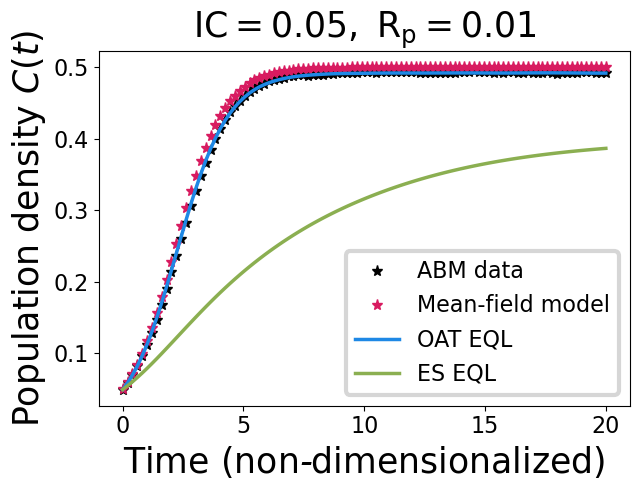

In [16]:
# Example fit with OAT EQL
m       = 0.05     # initial condition
degrees = 10
rm      = 1
rp      = 0.01
rd      = rp/2
# Format rp, rd for loading data
rp, rd = format_rp_rd(rp,rd)
max_param_size = 100
num_real = 25 # number of simulation realizations
folder     = '../../data/ABM'
folder_eql = 'pickle_data_ABM'

# Load ABM data    
data  = np.load(folder+'/logistic_ABM_sim_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'_real'+str(num_real)+'.npy',allow_pickle=True).item()
t     = data['variables'][0];     t = t[:,0]
ABM   = data['variables'][1];     U = ABM[:,0]   
ABM_t = data['variables'][2]

# Parameters/set-up for forward solving the learned sindy models
tf      = 20/(rp-rd)  # final time
t_solve = np.linspace(0, tf, 100)
t_solve_span = (t_solve[0], t_solve[-1])
C0      = ABM[0] # the initial condition

# Coefficients from ES ME-EQL approach
# n = 500 # number of samples
coeff_C1_library = 0.36*rp
coeff_C2_library = -2.34*rp
coeff_C3_library = 5.6*rp
coeff_C4_library = -5*rp

# Mean-field coefficients
coeff_C1_mfld = rp/2
coeff_C2_mfld = -rp

# Load EQL results
pickle_filename = folder_eql+'/eql_bdm_coeffs_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'_real25.pkl'   
with open(pickle_filename,'rb') as handle:
    data = pickle.load(handle)
coeffs_sindy_opt  = data[0]
if m == 0.05:
    degs_sindy    = data[5] # Note: for m = 0.05, EQL was run with SINDy and pySINDy, so the relevant variables need to be extracted differently
elif m==0.25:
    degs_sindy    = data[3]

# Construct full coefficient vectors
coeff_full_sindy  = np.zeros(10)
for l in range(len(degs_sindy)):
    coeff_full_sindy[degs_sindy[l]] = coeffs_sindy_opt[l]

# Forward solve with the original learned coefficients
u_sindy = solve_ivp(BDM_RHS_eval, t_solve_span, C0, t_eval=t_solve, args = (coeff_full_sindy,degrees)).y.T
u_sindy = np.array(flatten_chain(u_sindy))

# Forward solve with library coefficients
coeff_library = [coeff_C1_library,coeff_C2_library,coeff_C3_library,coeff_C4_library] 
# Construct full coefficient vector
coeff_full_library  = np.zeros(10)
degs_library = [0,1,2,3] 
for l in range(len(degs_library)):
    coeff_full_library[degs_library[l]] = coeff_library[l]
u_library = solve_ivp(BDM_RHS_eval, t_solve_span, C0, t_eval=t_solve, args = (coeff_full_library,degrees)).y.T
u_library = np.array(flatten_chain(u_library))

# Forward solve with mean-field coefficients
xi_mfld  = [rp,rd]
sol_mfld = simulate_meanfield_model(t,m,xi_mfld)
u_mfld   = np.array(flatten_chain(sol_mfld))

# Plotting
fontsize = 25
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', titlesize=16)
t_solve_nondim = t_solve*(rp-rd)
fig, ax = plt.subplots(1, 1, figsize=(6.5,5), tight_layout=True)
ax.plot(t_solve_nondim,U,'*',label = "ABM data", color=color_data, markersize=8)
ax.plot(t_solve_nondim,u_mfld,'*',label = "Mean-field model", color=color_mfld, markersize=8)
ax.plot(t_solve_nondim,u_sindy,label = "OAT EQL", color=color_oat, linewidth=2.5)
ax.plot(t_solve_nondim,u_library,label = "ES EQL", color=color_es, linewidth=2.5)
# legend
legend = ax.legend(loc='best',fontsize=16)
frame = legend.get_frame()
frame.set_linewidth(3)
ax.set_title("$\mathrm{IC=" + str(m) + ", \ R_p=" + str(rp) +"}$",fontproperties=my_font,fontsize=fontsize)
ax.set_xlabel("$\mathrm{Time\ (non}$-$\mathrm{dimensionalized)}$",fontproperties=my_font,fontsize=fontsize)
ax.set_ylabel("$\mathrm{Population \ density \ \it{C(t)}}$",fontproperties=my_font,fontsize=fontsize)

Max sindy degree:
6


Text(0, 0.5, '$\\mathrm{Coefficients}$')

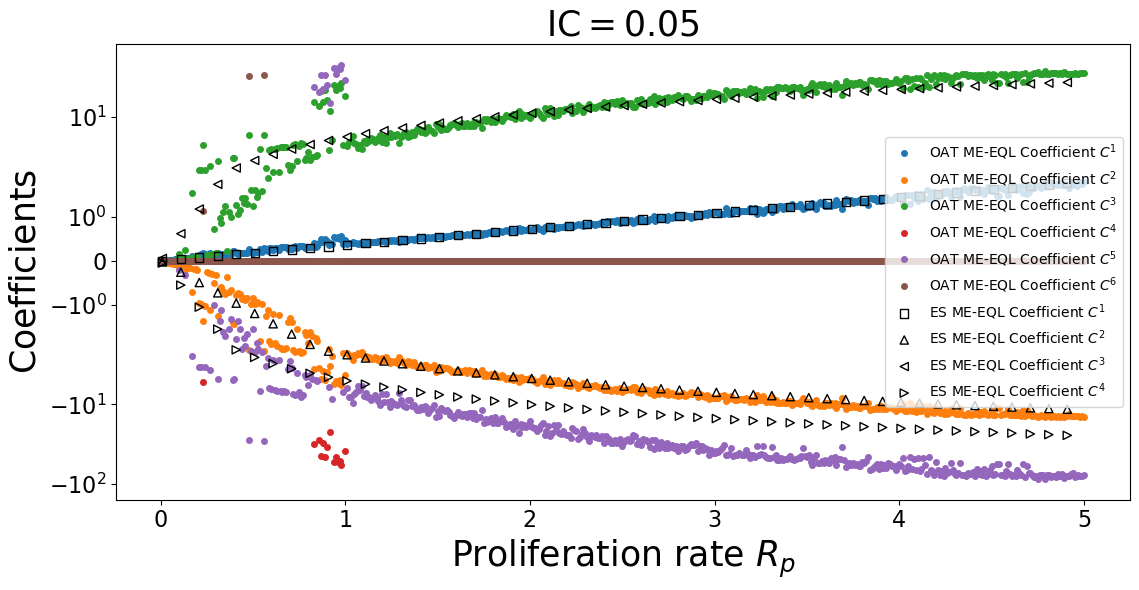

In [17]:
# Visualize learned coefficients from OAT EQL analysis
m  = 0.05     # initial condition
rm = 1        # migration
rp_vect = np.linspace(0.01,5,500)

# library for sindy
degrees        = 10
max_param_size = 100
num_real = 25 # number of simulation realizations
folder_eql = 'pickle_data_ABM'

lower_log = -9 # range for lambda
upper_log = -1
lmb_range = np.logspace(lower_log,upper_log,100)

coeff_C1_sindy = []
coeff_C2_sindy = []
coeff_C3_sindy = []
coeff_C4_sindy = []
coeff_C5_sindy = []
coeff_C6_sindy = []
coeff_C7_sindy = []
coeff_C8_sindy = []
coeff_C9_sindy = []
coeff_C10_sindy = []
degs_sindy_vect = []
degs_sindy_all  = []
lmb_opt_all     = []

# max degree across parameters
max_sindy  = 0

for rp in rp_vect:
    rd = rp/2 # death
    rp, rd = format_rp_rd(rp,rd)

    # Load EQL results
    pickle_filename = folder_eql+'/eql_bdm_coeffs_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'_real25.pkl'   
    with open(pickle_filename,'rb') as handle:
        data = pickle.load(handle)
    coeffs_sindy_opt  = data[0]
    if m == 0.05:
        degs_sindy    = data[5]
    elif m==0.25:
        degs_sindy    = data[3]

    degs_sindy_all.append(np.array(degs_sindy))

    if np.max(degs_sindy)>max_sindy:
        max_sindy = np.max(degs_sindy)

    # Construct full coefficient vectors
    coeff_full_sindy  = np.zeros(10)
    for l in range(len(degs_sindy)):
        coeff_full_sindy[degs_sindy[l]] = coeffs_sindy_opt[l]

    coeff_C1_sindy.append(coeff_full_sindy[0])
    coeff_C2_sindy.append(coeff_full_sindy[1])
    coeff_C3_sindy.append(coeff_full_sindy[2])
    coeff_C4_sindy.append(coeff_full_sindy[3])
    coeff_C5_sindy.append(coeff_full_sindy[4])
    coeff_C6_sindy.append(coeff_full_sindy[5])
    coeff_C7_sindy.append(coeff_full_sindy[6])
    coeff_C8_sindy.append(coeff_full_sindy[7])
    coeff_C9_sindy.append(coeff_full_sindy[8])
    coeff_C10_sindy.append(coeff_full_sindy[9])
    degs_sindy_vect.append(np.max(degs_sindy)+1)

print("Max sindy degree:")
print(max_sindy+1) # because indices start at 0

# Coefficients learned: ES ME-EQL
n = 500 # number of samples used
if m == 0.05:
    coeff_C1_library = 0.36*rp_vect
    coeff_C2_library = -2.34*rp_vect
    coeff_C3_library = 5.6*rp_vect
    coeff_C4_library = -5*rp_vect
elif m == 0.25:
    coeff_C1_library = 0.34*rp_vect
    coeff_C2_library = -0.85*rp_vect

# Coefficients learned
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', titlesize=14)
fig, ax = plt.subplots(1, 1, figsize=(11.5,6), tight_layout=True)

ax.plot(rp_vect,coeff_C1_sindy,"o",markersize=4,label = "OAT ME-EQL Coefficient $C^1$") 
ax.plot(rp_vect,coeff_C2_sindy,"o",markersize=4,label = "OAT ME-EQL Coefficient $C^2$")
ax.plot(rp_vect,coeff_C3_sindy,"o",markersize=4,label = "OAT ME-EQL Coefficient $C^3$")
ax.plot(rp_vect,coeff_C4_sindy,"o",markersize=4,label = "OAT ME-EQL Coefficient $C^4$") 
ax.plot(rp_vect,coeff_C5_sindy,"o",markersize=4,label = "OAT ME-EQL Coefficient $C^5$")
ax.plot(rp_vect,coeff_C6_sindy,"o",markersize=4,label = "OAT ME-EQL Coefficient $C^6$")

ax.scatter(rp_vect[::10],coeff_C1_library[::10],s=35,marker="s",facecolors='none',edgecolors='black',label = "ES ME-EQL Coefficient $C^1$",zorder=5) 
ax.scatter(rp_vect[::10],coeff_C2_library[::10],s=35,marker="^",facecolors='none',edgecolors='black',label = "ES ME-EQL Coefficient $C^2$",zorder=5)
if  m==0.05:
    ax.scatter(rp_vect[::10],coeff_C3_library[::10],s=35,marker="<",facecolors='none',edgecolors='black',label = "ES ME-EQL Coefficient $C^3$",zorder=5) 
    ax.scatter(rp_vect[::10],coeff_C4_library[::10],s=35,marker=">",facecolors='none',edgecolors='black',label = "ES ME-EQL Coefficient $C^4$",zorder=5) 

# legend
ax.legend(loc='best')
ax.set_yscale('symlog')
ax.set_title("$\mathrm{IC=" + str(m) +"}$",fontproperties=my_font,fontsize=fontsize)
ax.set_xlabel("$\mathrm{Proliferation\ rate\ \it{R_p}}$",fontproperties=my_font,fontsize=fontsize)
ax.set_ylabel("$\mathrm{Coefficients}$",fontproperties=my_font,fontsize=fontsize)

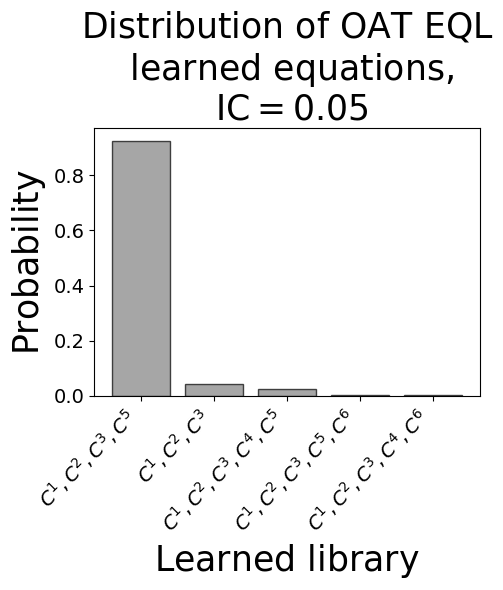

In [18]:
# Visualize frequency/probability of learned models
# Convert arrays to tuples to make them hashable
hashable_data = [tuple(arr) for arr in degs_sindy_all]

# Count the frequency of each unique array
frequency_count = Counter(hashable_data)

# Extract unique arrays and their frequencies
unique_arrays = list(frequency_count.keys())
frequencies = list(frequency_count.values())

unique_arrays_tmp = []
for array in unique_arrays:
    array_tmp = [int(arr) for arr  in array]
    unique_arrays_tmp.append(array_tmp)
unique_arrays = unique_arrays_tmp

# Prepare data for the histogram
labels = [convert_array_to_array_label(array) for array in unique_arrays]

# Convert frequencies to probabilities
total = np.sum(frequencies)
probabilities = frequencies / total  # Normalize to sum to 1

### sort lowest to highest
sorting_indices = np.argsort(probabilities)
### sort highest to lowest
sorting_indices = sorting_indices[::-1]
### sort probabilities and labels
probabilities_sorted = probabilities[sorting_indices]
labels_sorted = [labels[ind] for ind in sorting_indices]

# Plot the histogram
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=14)
fig, ax = plt.subplots(1, 1, figsize=(5,6), tight_layout=True)
plt.bar(labels_sorted, probabilities_sorted, color='grey', alpha=0.7, edgecolor='black')

# Add labels and title
plt.xlabel('$\mathrm{Learned\ library}$',fontproperties=my_font,fontsize=fontsize)
plt.ylabel('$\mathrm{Probability}$',fontproperties=my_font,fontsize=fontsize)
plt.title('$\mathrm{Distribution\ of\ OAT\ EQL}$' +'\n $\mathrm{learned\ equations,}$' +'\n $\mathrm{IC=' + str(m)+"}$",fontproperties=my_font,fontsize=fontsize)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()

5
4
Coeffs of C^1
[-0.02475829  0.18641541 -0.06517328  0.28959621]
Coeffs of C^2
[ 0.21976331 -1.76940964  1.20248551 -1.89560897]
Coeffs of C^3
[-0.51640509  4.45082879 -3.39751583  3.70689379]
Coeffs of C^5
[ 0.71632493 -7.54960316  4.69345971 -4.04215344]


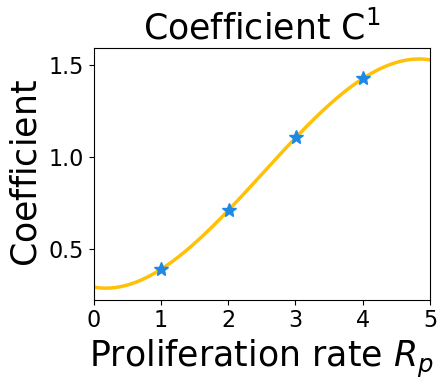

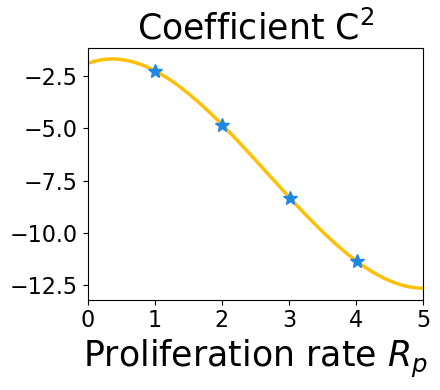

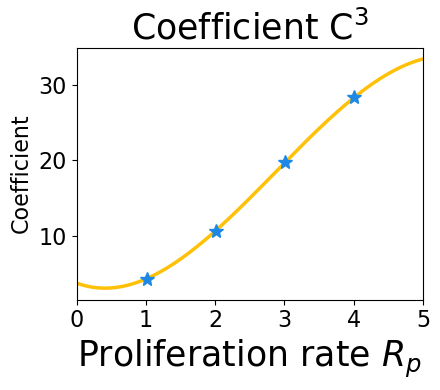

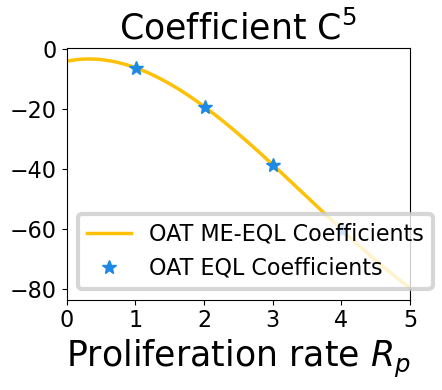

In [20]:
# Set up OAT ME-EQL interpolation

# Sparsify coefficients and evaluate what models are learned
drp  = 1 # delta Rp between data points considered for training; options: 0.01,0.5,1 
evry        = round(drp/0.01)
rp_sparse_orig = np.arange(0.01,5,drp)
rp_sparse   = np.arange(0.01,5,drp)
inds_sparse = np.arange(0,500,evry)
n           = len(rp_vect[inds_sparse])
print(n)
degs_sindy_sparse = [degs_sindy_all[i] for i in inds_sparse]

if m == 0.05:
    target = [0,1,2,4] # degrees [0 1 2 4] are the most common among this subset
elif m == 0.25:
    target = [0,1,3] # degrees [0 1 3] are the most common among this subset
indices_temp = [i for i, value in enumerate(degs_sindy_sparse) if np.array_equal(value,target)]
inds_sparse_temp = inds_sparse[indices_temp]
print(len(inds_sparse_temp))
inds_sparse = inds_sparse_temp

# Take sparse selection of indices and fit
rp_sparse   = rp_vect[inds_sparse]
coeff_C1_sparse = [coeff_C1_sindy[i] for i in inds_sparse]
coeff_C2_sparse = [coeff_C2_sindy[i] for i in inds_sparse]
if m == 0.05:
    coeff_C3_sparse = [coeff_C3_sindy[i] for i in inds_sparse]
    coeff_C5_sparse = [coeff_C5_sindy[i] for i in inds_sparse]
elif m == 0.25:
    coeff_C4_sparse = [coeff_C4_sindy[i] for i in inds_sparse]
# For fitting
sigma     = np.ones(len(rp_sparse))

# Plot of fits
# Coefficients learned: OAT-EQL
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', titlesize=16)

if m == 0.25 and drp==1:  # Have to fit to a line in this situation, since only have 2 datapoints to fit through
    fig, ax = plt.subplots(1, 3, figsize=(8,4), tight_layout=True)
    # Fit coefficients C^1
    popt, pcov       = curve_fit(f_line,rp_sparse,coeff_C1_sparse,sigma=sigma) # data x, y to fit
    coeff_C1_fit     = f_line(np.array(rp_sparse), *popt)
    coeff_C1_fitfull = f_line(np.array(rp_vect), *popt)
    print('Coeffs of C^1')
    print(popt)

    ax[0].plot(rp_sparse,coeff_C1_fit, color = color_oatinterp, linewidth=2.5) 
    ax[0].plot(rp_sparse,coeff_C1_sparse,'*', color = color_oat, linewidth=2.5)
    ax[0].set_xlim(0,5)
    ax[0].set_title('Coefficient $C^1$')
    ax[0].set_xlabel("ABM proliferation rate $R_p$")
    ax[0].set_ylabel("Coefficient")

    # Fit coefficients C^2
    popt, pcov       = curve_fit(f_line,rp_sparse,coeff_C2_sparse,sigma=sigma) # data x, y to fit
    coeff_C2_fit     = f_line(np.array(rp_sparse), *popt)
    coeff_C2_fitfull = f_line(np.array(rp_vect), *popt)
    print('Coeffs of C^2')
    print(popt)
    
    ax[1].plot(rp_sparse,coeff_C2_fit, color = color_oatinterp, linewidth=2.5) #,label = "OAT ME-EQL Coefficient $C^2$"
    ax[1].plot(rp_sparse,coeff_C2_sparse,'*', color = color_oat, linewidth=2.5) #,label = "OAT EQL Coefficient $C^2$"
    ax[1].set_title('Coefficient $C^2$')
    ax[1].set_xlim(0,5)
    ax[1].set_xlabel("ABM proliferation rate $R_p$")

    # Fit coefficients C^4
    popt, pcov       = curve_fit(f_line,rp_sparse,coeff_C4_sparse,sigma=sigma) # data x, y to fit
    coeff_C4_fit     = f_line(np.array(rp_sparse), *popt)
    coeff_C4_fitfull = f_line(np.array(rp_vect), *popt)
    print('Coeffs of C^4')
    print(popt)

    ax[2].plot(rp_sparse,coeff_C4_fit,label = "OAT ME-EQL Coefficients", color = color_oatinterp, linewidth=2.5)
    ax[2].plot(rp_sparse,coeff_C4_sparse,'*',label = "OAT EQL Coefficients", color = color_oat, linewidth=2.5)
    ax[2].set_xlim(0,5)
    ax[2].set_title('Coefficient $C^4$')
    ax[2].legend(loc='lower left')
    ax[2].set_xlabel("ABM proliferation rate $R_p$")

else:     # in any other situation
    # Fit coefficients C^1
    popt, pcov       = curve_fit(f_poly3,rp_sparse,coeff_C1_sparse,sigma=sigma) # data x, y to fit
    coeff_C1_fit     = f_poly3(np.array(rp_sparse), *popt)
    coeff_C1_fitfull = f_poly3(np.array(rp_vect), *popt)
    print('Coeffs of C^1')
    print(popt)
    
    fig, ax = plt.subplots(1, 1, figsize=(4.5,4), tight_layout=True)
    ax.plot(rp_vect,coeff_C1_fitfull, color = color_oatinterp, linewidth=2.5) 
    ax.plot(rp_sparse,coeff_C1_sparse,'*', color = color_oat, markersize=10)
    ax.set_xlim(0,5)
    ax.set_title("$\mathrm{Coefficient \ C^1}$",fontproperties=my_font,fontsize=fontsize)
    ax.set_xlabel("$\mathrm{Proliferation\ rate\ \it{R_p}}$",fontproperties=my_font,fontsize=fontsize)
    ax.set_ylabel("$\mathrm{Coefficient}$",fontproperties=my_font,fontsize=fontsize)
    
    # Fit coefficients C^2
    popt, pcov       = curve_fit(f_poly3,rp_sparse,coeff_C2_sparse,sigma=sigma) # data x, y to fit
    coeff_C2_fit     = f_poly3(np.array(rp_sparse), *popt)
    coeff_C2_fitfull = f_poly3(np.array(rp_vect), *popt)
    print('Coeffs of C^2')
    print(popt)
    
    fig, ax = plt.subplots(1, 1, figsize=(4.5,4), tight_layout=True)
    # ax.plot(rp_sparse,coeff_C2_fit, color = color_oatinterp, linewidth=2.5)
    ax.plot(rp_vect,coeff_C2_fitfull, color = color_oatinterp, linewidth=2.5) 
    ax.plot(rp_sparse,coeff_C2_sparse,'*', color = color_oat, markersize=10)
    ax.set_xlim(0,5)
    ax.set_title("$\mathrm{Coefficient \ C^2}$",fontproperties=my_font,fontsize=fontsize)
    ax.set_xlabel("$\mathrm{Proliferation\ rate\ \it{R_p}}$",fontproperties=my_font,fontsize=fontsize)
    
    if m == 0.05:
        # Fit coefficients C^3
        popt, pcov       = curve_fit(f_poly3,rp_sparse,coeff_C3_sparse,sigma=sigma) # data x, y to fit
        coeff_C3_fit     = f_poly3(np.array(rp_sparse), *popt)
        coeff_C3_fitfull = f_poly3(np.array(rp_vect), *popt)
        print('Coeffs of C^3')
        print(popt)
    
        fig, ax = plt.subplots(1, 1, figsize=(4.5,4), tight_layout=True)
        # ax[2].plot(rp_sparse,coeff_C3_fit, color = color_oatinterp, linewidth=2.5)
        ax.plot(rp_vect,coeff_C3_fitfull, color = color_oatinterp, linewidth=2.5) 
        ax.plot(rp_sparse,coeff_C3_sparse,'*', color = color_oat, markersize=10) 
        ax.set_xlim(0,5)
        ax.set_title("$\mathrm{Coefficient \ C^3}$",fontproperties=my_font,fontsize=fontsize)
        ax.set_xlabel("$\mathrm{Proliferation\ rate\ \it{R_p}}$",fontproperties=my_font,fontsize=fontsize)
        ax.set_ylabel("Coefficient")
        
        # Fit coefficients C^5
        popt, pcov       = curve_fit(f_poly3,rp_sparse,coeff_C5_sparse,sigma=sigma) # data x, y to fit
        coeff_C5_fit     = f_poly3(np.array(rp_sparse), *popt)
        coeff_C5_fitfull = f_poly3(np.array(rp_vect), *popt)
        print('Coeffs of C^5')
        print(popt)
    
        fig, ax = plt.subplots(1, 1, figsize=(4.5,4), tight_layout=True)
        # ax[3].plot(rp_sparse,coeff_C5_fit,label = "OAT ME-EQL Coefficients", color = color_oatinterp, linewidth=2.5)
        ax.plot(rp_vect,coeff_C5_fitfull,label = "OAT ME-EQL Coefficients", color = color_oatinterp, linewidth=2.5)     
        ax.plot(rp_sparse,coeff_C5_sparse,'*',label = "OAT EQL Coefficients", color = color_oat, markersize=10)
        ax.set_xlim(0,5)
        ax.set_title("$\mathrm{Coefficient \ C^5}$",fontproperties=my_font,fontsize=fontsize)
        # legend
        legend = ax.legend(loc='lower left',fontsize=16)
        frame = legend.get_frame()
        frame.set_linewidth(3)
        ax.set_xlabel("$\mathrm{Proliferation\ rate\ \it{R_p}}$",fontproperties=my_font,fontsize=fontsize)
    
    elif m == 0.25:
        # Fit coefficients C^4
        popt, pcov       = curve_fit(f_poly3,rp_sparse,coeff_C4_sparse,sigma=sigma) # data x, y to fit
        coeff_C4_fit     = f_poly3(np.array(rp_sparse), *popt)
        coeff_C4_fitfull = f_poly3(np.array(rp_vect), *popt)
        print('Coeffs of C^4')
        print(popt)
    
        fig, ax = plt.subplots(1, 1, figsize=(4.5,4), tight_layout=True)
        ax.plot(rp_vect,coeff_C4_fitfull,label = "OAT ME-EQL Coefficients", color = color_oatinterp, linewidth=2.5)     
        ax.plot(rp_sparse,coeff_C4_sparse,'*',label = "OAT EQL Coefficients", color = color_oat, markersize=10)
        ax.set_xlim(0,5)
        ax.set_ylim(-4,70)
        ax.set_title("$\mathrm{Coefficient \ C^4}$",fontproperties=my_font,fontsize=fontsize)
        # legend
        legend = ax.legend(loc='upper left',fontsize=16)
        frame = legend.get_frame()
        frame.set_linewidth(3)
        ax.set_xlabel("$\mathrm{Proliferation\ rate\ \it{R_p}}$",fontproperties=my_font,fontsize=fontsize)
        

In [21]:
# Coefficients learned: ES ME-EQL approach
# n: number of samples for sparsification
if n == 10 and m == 0.05:
    coeff_C1_library = 0.4*rp_vect
    coeff_C2_library = -2.53*rp_vect
    coeff_C3_library = 5.81*rp_vect
    coeff_C4_library = -4.92*rp_vect
elif n== 5 and m == 0.05:
    coeff_C1_library = 0.42*rp_vect
    coeff_C2_library = -2.37*rp_vect
    coeff_C3_library = 3.92*rp_vect
    coeff_C5_library = -3.84*rp_vect
elif n == 10 and m == 0.25:
    coeff_C1_library = 0.85*rp_vect
    coeff_C2_library = -2.95*rp_vect  
    coeff_C4_library = 5.24*rp_vect 
elif n == 5 and m == 0.25:
    coeff_C1_library = 0.86*rp_vect
    coeff_C2_library = -2.92*rp_vect 
    coeff_C4_library = 4.94*rp_vect 

In [27]:
# Calculate MSE error with coefficients from interpolated curves
mse_sindy   = np.zeros(len(rp_vect))
mse_interp  = np.zeros(len(rp_vect))
mse_library = np.zeros(len(rp_vect))
mse_mfld    = np.zeros(len(rp_vect))
folder_eql = 'pickle_data_ABM'

for j in range(len(rp_vect)): 
    
    rp = rp_vect[j]
    rd = rp/2 
    rp, rd = format_rp_rd(rp,rd)
        
    # Load ABM data    
    data = np.load(folder+'/logistic_ABM_sim_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'_real'+str(num_real)+'.npy',allow_pickle=True).item()
    t     = data['variables'][0];     t = t[:,0]
    ABM   = data['variables'][1];     U = ABM[:,0]   
    ABM_t = data['variables'][2]
 
    # Parameters/set-up for forward solving the learned sindy models
    tf      = 20/(rp-rd)  # final time
    t_solve = np.linspace(0, tf, 100)
    t_solve_span = (t_solve[0], t_solve[-1])
    C0 = m # the initial condition

    # Load EQL results
    pickle_filename = folder_eql+'/eql_bdm_coeffs_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'_real25.pkl'   
    with open(pickle_filename,'rb') as handle:
        data = pickle.load(handle)
    coeffs_sindy_opt  = data[0]
    if m == 0.05:
        degs_sindy    = data[5]
    elif m==0.25:
        degs_sindy    = data[3]
    
    # Construct full coefficient vectors
    coeff_full_sindy  = np.zeros(10)
    for l in range(len(degs_sindy)):
        coeff_full_sindy[degs_sindy[l]] = coeffs_sindy_opt[l]

    # Forward solve with the original learned coefficients
    C0 = [C0]
    u_sindy = solve_ivp(BDM_RHS_eval, t_solve_span, C0, t_eval=t_solve, args = (coeff_full_sindy,degrees)).y.T
    u_sindy = np.array(flatten_chain(u_sindy))

    # Forward solve with interpolated coefficients
    if m == 0.05:
        coeff_interp = [coeff_C1_fitfull[j],coeff_C2_fitfull[j],coeff_C3_fitfull[j],coeff_C5_fitfull[j]] 
        degs_interp = [0,1,2,4] 
    elif m == 0.25:
        coeff_interp = [coeff_C1_fitfull[j],coeff_C2_fitfull[j],coeff_C4_fitfull[j]] 
        degs_interp = [0,1,3] 
        
    # Construct full coefficient vector
    coeff_full_interp  = np.zeros(10)
    for l in range(len(degs_interp)):
        coeff_full_interp[degs_interp[l]] = coeff_interp[l]
    u_interp = solve_ivp(BDM_RHS_eval, t_solve_span, C0, t_eval=t_solve, args = (coeff_full_interp,degrees)).y.T
    u_interp = np.array(flatten_chain(u_interp))

    # Forward solve with coefficients from ES ME-EQL
    if m==0.05 and n==10:
        coeff_library = [coeff_C1_library[j],coeff_C2_library[j],coeff_C3_library[j],coeff_C4_library[j]] 
        degs_library = [0,1,2,3]
    elif m==0.05 and n==5:
        coeff_library = [coeff_C1_library[j],coeff_C2_library[j],coeff_C3_library[j],coeff_C5_library[j]] 
        degs_library = [0,1,2,4]

    if m == 0.25:
        coeff_library = [coeff_C1_library[j],coeff_C2_library[j],coeff_C4_library[j]] 
        degs_library = [0,1,3]
        
    # Construct full coefficient vector
    coeff_full_library  = np.zeros(10)
    for l in range(len(degs_library)):
        coeff_full_library[degs_library[l]] = coeff_library[l]
    u_library = solve_ivp(BDM_RHS_eval, t_solve_span, C0, t_eval=t_solve, args = (coeff_full_library,degrees)).y.T
    u_library = np.array(flatten_chain(u_library))

    # Forward solve with mean-field coefficients
    xi_mfld  = [rp,rd]
    sol_mfld = simulate_meanfield_model(t,m,xi_mfld)
    u_mfld   = np.array(flatten_chain(sol_mfld))

    mse_sindy[j]   = MSE(U,u_sindy) # MSE between data and ODE solution with OAT EQL coefficients
    mse_interp[j]  = MSE(U,u_interp) # MSE between data and ODE solution with OAT ME-EQL coefficients
    mse_library[j] = MSE(U,u_library) # MSE between data and ODE solution with ES ME-EQL coefficients
    mse_mfld[j]    = MSE(U,u_mfld) # MSE between data and ODE solution with mean-field coefficients

mse_sindy_sparse = mse_sindy[inds_sparse]

Text(0, 0.5, '$\\mathrm{MSE}$')

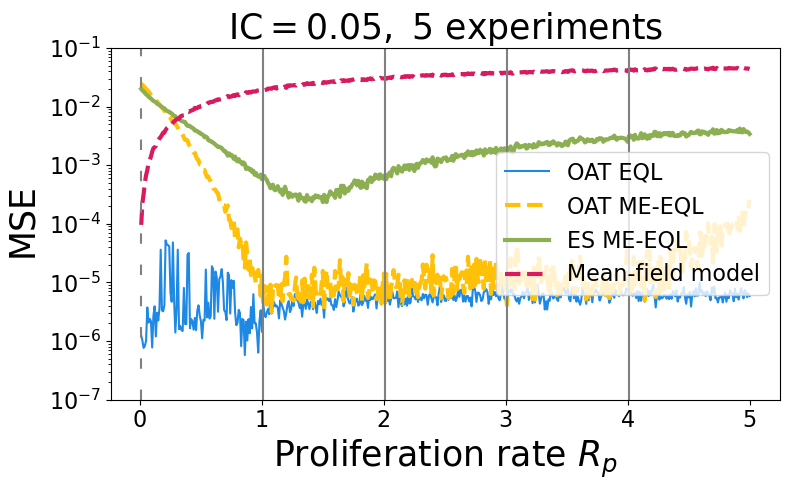

In [29]:
# Plot MSEs of fits from sparsification experiments
rp_sparse_filtered = list(set(rp_sparse_orig)-set(rp_sparse))

plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', titlesize=16)
fig, ax = plt.subplots(1, 1, figsize=(8,5), tight_layout=True)
ax.plot(rp_vect,mse_sindy,color = color_oat,label = "OAT EQL")
ax.plot(rp_vect,mse_interp,'--',color = color_oatinterp,label = "OAT ME-EQL", linewidth=3)
ax.plot(rp_vect,mse_library,color = color_es,label = "ES ME-EQL", linewidth=3)
ax.plot(rp_vect,mse_mfld,'--',color = color_mfld,label = "Mean-field model", linewidth=3)
if m == 0.05:
    ax.vlines(rp_sparse,10**(-7), 10**(-1),colors = 'grey',linestyles='solid')
    ax.vlines(rp_sparse_filtered,10**(-7), 10**(-1),colors = 'grey',linestyles=(0, (5, 10)))
    plt.legend(loc='best',fontsize=12)
    ax.set_ylim([10**(-7), 10**(-1)])
else:
    ax.vlines(rp_sparse,10**(-7), 10**(-1),colors = 'grey',linestyles='solid')
    ax.vlines(rp_sparse_filtered,10**(-7), 10**(-1),colors = 'grey',linestyles=(0, (5, 10)))
    plt.legend(loc='best',fontsize=12)
    ax.set_ylim([10**(-7), 10**(-1)])
#legend
legend = ax.legend(loc='best',fontsize=16)
ax.set_title("$\mathrm{IC="+ str(m) + ",\ " + str(n) + "\ experiments}$",fontproperties=my_font,fontsize=fontsize)
ax.set_yscale('log')
ax.set_xlabel("$\mathrm{Proliferation\ rate\ \it{R_p}}$",fontproperties=my_font,fontsize=fontsize)
ax.set_ylabel("$\mathrm{MSE}$",fontproperties=my_font,fontsize=fontsize)